In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

# Her i starten indlæses bare data og korrigeres for k_acc, som vi har gjort tidligere. Led efter næste markdown, hvor der står, at der er ændringer

In [4]:
rådata = pd.read_excel('Ægte_DailyMinMax_Ilullisat_Cor-2.xlsx')
print(rådata)
data = rådata.to_numpy()
år_rå, temp_rå = data[:,0], data[:,1]

               Yr       Temp  Completeness
0       1873.0000 -20.131622             2
1       1873.0014 -12.826645             2
2       1873.0027 -20.587018             2
3       1873.0041 -12.755726             2
4       1873.0055 -21.348169             2
...           ...        ...           ...
108109  2020.9932  -3.317742             0
108110  2020.9945  -4.417742             0
108111  2020.9959   1.182258             0
108112  2020.9973   0.000000             0
108113  2020.9986   0.000000             0

[108114 rows x 3 columns]


In [5]:
def interpolation_år():
    interpol_år = []
    år = []
    temp = []
    for i in range(1, len(år_rå)):      # Finder mellempunkter for årsarrayet
        punkt = (år_rå[i] + år_rå[i-1])/2
        interpol_år.append(punkt)

    for i in range(len(interpol_år)):   # Laver liste med både DMI-årstal og mellempunkter
        år.append(år_rå[i])
        år.append(interpol_år[i])
    år.append(år_rå[-1])   # Tilføjer det sidste rå datapunkt manuelt, da der et ét råt datapunkt mere end mellempunkterne.
    return np.array([år])
    
år = interpolation_år()      # Interpolerer temperaturdataen
år = år[0]

temp = np.interp(år, år_rå, temp_rå)


In [6]:
råsatellit = pd.read_csv('greenland_mass_200204_202311.txt', delimiter = '\s+', header = None, skiprows = lambda x: x < 31)
satellit = råsatellit.to_numpy()
år_sat, dmasse_sat = satellit[:, 0], satellit[:, 1]
densitet_is = 917
dvol_sat = 10**12 * dmasse_sat/densitet_is   # Vi omregner massetilvækst til volumentilvækst
V_sat_err = 10**12 * abs(1/densitet_is * satellit[:,2])

In [7]:
# Slicing af DMI-data
top = max(år_sat)   
bund = min(år_sat)
temp = temp[(år <= top) & (år >= bund)] # Nyt temperatur-array, som kun indeholder temperaturer for samme årrække som satellitdata
år = år[(år <= top) & (år >= bund)] # Sørger for, at vi også har et årstals-array med de tilsvarende indgange (samme maske)

# Slicing af GRACE-data
topDMI = max(år)
dmasse_sat = dmasse_sat[år_sat <= topDMI]
dvol_sat = dvol_sat[år_sat <= topDMI]
V_sat_err = V_sat_err[år_sat <= topDMI]
år_sat = år_sat[år_sat <= topDMI]

In [8]:
råNGRIP = pd.read_excel('rådata NGRIP_acc_Vinther_etal_2009_GICC05_16Sep2010.xlsx', header = 58, usecols = [0,1,2,3,4,5,6,7,8])
råGRIP = pd.read_excel('GRIP_acc_Vinther_etal_2009_GICC05_16Sep2010.xlsx', header = 54, usecols = [0,1,2,3,4,5,6,7])

NGRIP, GRIP = råNGRIP.to_numpy(), råGRIP.to_numpy()
NGRIPakk0, GRIPakk0 = NGRIP[:, 6], GRIP[:, 5]
NGRIPår0, GRIPår0 = NGRIP[:, 1], GRIP[:, 1]

In [9]:
akk_list = (NGRIPakk0[1:21] + GRIPakk0[1:21])/2   # Tager ikke første punkt med grunden manglende nedbørsdata
akk_gns = np.mean(akk_list)
print('gns akkumulation = ', akk_gns)

gns akkumulation =  0.2034321448890318


In [78]:
dvol_sat_korr = dvol_sat - np.mean(dvol_sat) # volumenændringer for GRACE korrigeres, så det har nulpunkt i sit gennemsnit


V_start = 2.85 * 10**15   # startvolumen af iskappe
V = V_start  # startvolumen af iskappe
V_0 = V_start 
V_sat = dvol_sat + V_0 - dvol_sat[0]
h = 3 * 10**3       # Starthøjde af iskappe
R = 500 * 10**3     # Startradius af iskappe
T_f = 0        
alfa = - 9.8 * 10**(-3)  # konstant hvormed temperatur stiger per meter
k = h/np.sqrt(R)   # formfaktor for iskappe. Antages global konstant
dt = 1/(365.25 * 4)  # Tidsskridt (her 1/4 døgn) - omregnet til år

# Tuningskonstanter
# k_melt = 8.4 * 10**(-1)   # Smeltekonstanten (Det er denne, vi har varieret på for at få graferne til at overlappe)
# På et år smelter ca. 10 cm ned 
acc = akk_gns   # Nedbør pr år [m/år]. Antages konstant i perioden
k_acc = 1   # Denne tuningskonstant kommer fra vores undervurdering af nedbøren. Den kan vi også tune på, hvis nødvendigt. 
k_melt = 1

# Der oprettes tomme lister til resultatet af simuleringen
V_list = []
V_melt_list = []
V_acc_list = []


for i in range(len(år)):
    R = (3/16 * V/k)**(2/5)     # Ny radius af iskappe
    
    V_acc = k_acc * (acc * 8 * R**2) * dt  # Nedbøret dette tidsskridt
    
    if temp[i] - T_f <= 0:
        V_melt = 0
    elif temp[i] - T_f > 0:
        V_melt = k_melt * 8/3 * R * (temp[i] - T_f) * ((T_f - temp[i])/(alfa * k))**2 * dt  # ganger tidsskridt og M på
    V += V_acc - V_melt
    
    V_list.append(V)
    V_melt_list.append(V_melt)
    V_acc_list.append(V_acc)

   
V_sum = np.sum(V_acc_list)/(år[-1] - år[0])
V_forventet = (642 * 10**12)/(densitet_is) #m^3

k_acc = V_forventet/V_sum
print('k_acc =', k_acc)


k_acc = 2.255739076054341


# __HERFRA NYT__

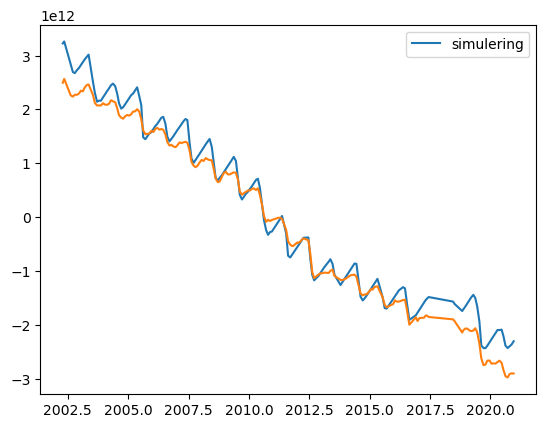

In [72]:
V_start = 2.85 * 10**15   # startvolumen af iskappe
dvol_sat_korr = dvol_sat - np.mean(dvol_sat) # volumenændringer for GRACE korrigeres, så det har nulpunkt i sit gennemsnit
dvol_sat_err_korr = np.sqrt(V_sat_err**2 + (np.std(V_sat)/np.sqrt(len(V_sat)))**2)

def simulering(år_sat, k_melt):
    
    # De globale konstanter defineres
    V = V_start  # startvolumen af iskappe
    V_0 = V_start 
    h = 3 * 10**3       # Starthøjde af iskappe
    R = 500 * 10**3     # Startradius af iskappe
    T_f = 0        
    alfa = - 9.8 * 10**(-3)  # konstant hvormed temperatur stiger per meter
    k = h/np.sqrt(R)   # formfaktor for iskappe. Antages global konstant
    dt = 1/(365.25 * 4)  # Tidsskridt (her 1/4 døgn) - omregnet til år
    
    # Tuningskonstanter
    # k_melt = 8.4 * 10**(-1)   # Smeltekonstanten (Det er denne, vi har varieret på for at få graferne til at overlappe)
    # På et år smelter ca. 10 cm ned 
    acc = akk_gns   # Nedbør pr år [m/år]. Antages konstant i perioden

    
    # Der oprettes tomme lister til resultatet af simuleringen
    V_list = []
    V_melt_list = []
    V_acc_list = []
    
    
    for i in range(1, len(år) + 1):
        R = (3/16 * V/k)**(2/5)     # Ny radius af iskappe
        
        V_acc = k_acc * (acc * 8 * R**2) * dt  # Nedbøret dette tidsskridt
        
        if temp[-i] - T_f <= 0:
            V_melt = 0
        elif temp[-i] - T_f > 0:
            V_melt = k_melt * 8/3 * R * (temp[-i] - T_f) * ((T_f - temp[-i])/(alfa * k))**2 * dt  # ganger tidsskridt og M på
        V +=  - V_acc + V_melt
        
        V_list.append(V)
        V_melt_list.append(V_melt)
        V_acc_list.append(V_acc)
    
    V_list.reverse()

    dvol_sim = V_list - np.mean(V_list)

    dvol_sim_fit = np.interp(år_sat, år, dvol_sim)
    #print('år', år)
    #print('dvolsim', dvol_sim)
    #print('dvol fit', dvol_sim_fit)

    return dvol_sim_fit 


# Nedenstående er bare et tjek af den nye funktion, som er lidt anderledes end de gamle
test = simulering(år_sat, 6.977977977977978)

#plt.plot(år, V_list)
plt.plot(år_sat, test, label = 'simulering')
plt.plot(år_sat, dvol_sat_korr)
plt.legend()


## Curve_fit

In [79]:
par, cov = curve_fit(simulering, år_sat, dvol_sat_korr, p0 = 1, sigma = dvol_sat_err_korr, absolute_sigma= True)
print(par)
print(np.sqrt(cov[0]))

[6.9794851]
[0.0113895]


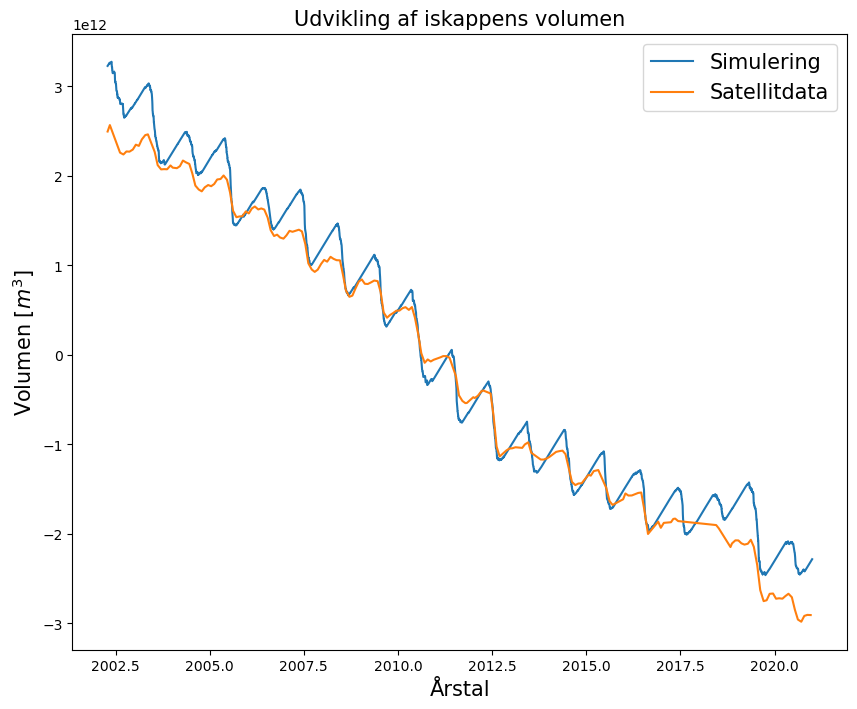

In [75]:
# De globale konstanter defineres
V_0 = 2.85 * 10**15
V = 2.85 * 10**15   # startvolumen af iskappe
h = 3 * 10**3       # Starthøjde af iskappe
R = 500 * 10**3     # Startradius af iskappe
T_f = 0        
alfa = - 9.8 * 10**(-3)  # konstant hvormed temperatur stiger per meter
k = h/np.sqrt(R)   # formfaktor for iskappe. Antages global konstant
dt = 1/(365.25 * 4)  # Tidsskridt (her 1/2 døgn) - omregnet til år

# Tuningskonstanter
k_melt = par[0]
acc = akk_gns   # Nedbør pr år [m/år]. Antages konstant i perioden


# Der oprettes tomme lister til resultatet af simuleringen
V_list = []
V_melt_list = []
V_acc_list = []


for i in range(1, len(år) + 1):
    R = (3/16 * V/k)**(2/5)     # Ny radius af iskappe
    
    V_acc = k_acc * (acc * 8 * R**2) * dt  # Nedbøret dette tidsskridt
    
    if temp[-i] - T_f <= 0:
        V_melt = 0 
    elif temp[-i] - T_f > 0:
        V_melt = k_melt * 8/3 * R * (temp[-i] - T_f) * ((T_f - temp[-i])/(alfa * k))**2 * dt # ganger tidsskridt og M på
    V +=  - V_acc + V_melt
    
    V_list.append(V)
    V_melt_list.append(V_melt)
    V_acc_list.append(V_acc)

V_list.reverse()
dvol_sim = V_list - np.mean(V_list)
    
# Plot
    
plt.figure(figsize = (10,8))
plt.plot(år , dvol_sim, label = 'Simulering')
plt.xlabel('Årstal', fontsize = 15)
plt.ylabel(r'Volumen $[m^3]$', fontsize = 15)
plt.title('Udvikling af iskappens volumen', fontsize = 15)

plt.plot(år_sat, dvol_sat_korr, label = 'Satellitdata')
plt.legend(fontsize = 15)
plt.savefig('Tuning af smeltekonstant.png')
